In [5]:
from tensorboard.backend.event_processing import event_accumulator

import matplotlib.pyplot as plt
from matplotlib.axis import Axis

from tabulate import tabulate
import seaborn as sns
from tqdm import tqdm

from typing import Literal, List
import warnings
import os

warnings.filterwarnings('ignore')
%cd ~/GitLab/bev2seg_2/

MODELS_PATH = "./models"

COLOR_PALETTE = [
    "#FF0064",
    "#FF62A0",
    "#0277BD",
    "#2AB0D2",
    "#7700A0",
    "#B200EF",
    "#00A032",
    "#03FF52",
    "#FF9800",
    "#FFB03B",
    "#C00071",
    "#FF37AD",
    "#00A697",
    "#44FFEE",
]


/home/VICOMTECH/agarciaj/GitLab/bev2seg_2


In [6]:
def load_models_data(models_path:str, 
    selected_type:Literal["bev", "nu"], 
    scalar_tags:List[str]=["eval/loss", "eval/mean_accuracy", "eval/mean_iou", "eval/overall_accuracy", "train/learning_rate", "train/loss"]
    ) -> dict:
    # SCALAR TAGS:
    # "eval/loss", "eval/mean_accuracy", "eval/mean_iou", "eval/overall_accuracy", "eval/runtime", "eval/samples_per_second", "eval/steps_per_second"
    # "train/epoch", "train/grad_norm", "train/learning_rate", "train/loss", "train/total_flos", "train/train_loss", "train/train_runtime", "train/train_samples_per_second", "train/train_steps_per_second"

    models_path     = "./models"
    map_selection   = { "bev": "segformer_bev", "nu": "segformer_nu_formatted" }
    runs_path = os.path.join(models_path, map_selection[selected_type], "runs")

    models_data = {}

    # Iterar sobre subcarpetas (cada subcarpeta es un modelo)
    for model_name in os.listdir(runs_path):
        model_path = os.path.join(runs_path, model_name)
        if not os.path.isdir(model_path):
            continue

        # Buscar archivos de eventos en la subcarpeta
        for root, _, files in os.walk(model_path):
            for file in files:
                if file.startswith("events.out.tfevents"):
                    event_file = os.path.join(root, file)
                    ea = event_accumulator.EventAccumulator(event_file)
                    ea.Reload()

                    for st in ea.Tags()["scalars"]:
                        if st in scalar_tags:
                            scalar_events = ea.Scalars(st)
                            steps = [e.step for e in scalar_events]
                            values = [e.value for e in scalar_events]
                            if model_name not in models_data:
                                models_data[model_name] = {}
                            models_data[model_name][st] = (steps, values)
    show_models_data(models_data, selected_type=selected_type)
    return models_data

def show_models_data(models_data:dict, selected_type:str = ""):
    names = list(models_data.keys())
    tags = [list(models_data[n].keys()) for n in names]
    data = [ (n, t) for n, t in zip(names, tags)]
    inf = tabulate(data, headers=['Model name', 'Tags'])
    print(f"LOADED DATA [{selected_type}]:\n {inf}\n")


def plot_train_vs_eval_loss(models_data, model_name, checkpoint:int=None, label_name:str=None, colors:tuple = (COLOR_PALETTE[0], COLOR_PALETTE[7]), ax:Axis = None):
    label_name = model_name if label_name is None else label_name
    eval_steps, eval_vals = [], []
    for tag, (steps, vals) in models_data[model_name].items():
        if tag == "train/loss":
            if ax is not None:
                ax.plot(steps, vals, label=f"{label_name} train", color=colors[0])
            else:
                plt.plot(steps, vals, label=f"{label_name} train", color=colors[0])
        if tag == "eval/loss":
            eval_vals = vals
            eval_steps = steps
            if ax is not None:
                ax.plot(steps, vals, label=f"{label_name} eval", color=colors[1])
            else:
                plt.plot(steps, vals, label=f"{label_name} eval", color=colors[1])
    
    if checkpoint is not None:
        index = -1
        try:
            index = eval_steps.index(checkpoint)
            eval_steps.index()
        except:
            pass
        assert index != -1, "Checkpoint not found"
        if ax is not None:
            ax.plot(checkpoint, eval_vals[index], marker='x', color='gray', markersize=4, label="Checkpoint")

def plot_mIoU(models_data, model_name, checkpoint:int=None, label_name:str=None, color = COLOR_PALETTE[0], ax:Axis = None):
    label_name = model_name if label_name is None else label_name

    eval_steps, eval_vals = [], []
    for tag, (steps, vals) in models_data[model_name].items():
        if tag == "eval/mean_iou":
            eval_vals = vals
            eval_steps = steps
            if ax is not None:
                ax.plot(steps, vals, label=f"{label_name}", color=color)
            else:
                plt.plot(steps, vals, label=f"{label_name}", color=color)
                
    if checkpoint is not None:
        index = -1
        try:
            index = eval_steps.index(checkpoint)
            eval_steps.index()
        except:
            pass
        assert index != -1, "Checkpoint not found"
        if ax is not None:
            ax.plot(checkpoint, eval_vals[index], marker='x', color='gray', markersize=4, label="Checkpoint")

In [8]:
bev_logs = load_models_data(MODELS_PATH, "bev")
nu_logs = load_models_data(MODELS_PATH, "nu")

LOADED DATA [bev]:
 Model name                  Tags
--------------------------  ------------------------------------------------------------------------------------------------------------------
raw2bevseg_mit-b2_v0.4      ['train/loss', 'train/learning_rate', 'eval/loss', 'eval/mean_iou', 'eval/mean_accuracy', 'eval/overall_accuracy']
raw2bevseg_mit-b0_v0.3      ['train/loss', 'train/learning_rate', 'eval/loss', 'eval/mean_iou', 'eval/mean_accuracy', 'eval/overall_accuracy']
raw2bevseg_mit-b2_v0.3      ['train/loss', 'train/learning_rate', 'eval/loss', 'eval/mean_iou', 'eval/mean_accuracy', 'eval/overall_accuracy']
raw2bevseg_mit-b0_v0.4_new  ['train/loss', 'train/learning_rate', 'eval/loss', 'eval/mean_iou', 'eval/mean_accuracy', 'eval/overall_accuracy']
raw2bevseg_mit-b0_v0.1      ['train/loss', 'train/learning_rate', 'eval/loss', 'eval/mean_iou', 'eval/mean_accuracy', 'eval/overall_accuracy']
raw2bevseg_mit-b4_v0.1      ['train/loss', 'train/learning_rate', 'eval/loss', 'eval/mean

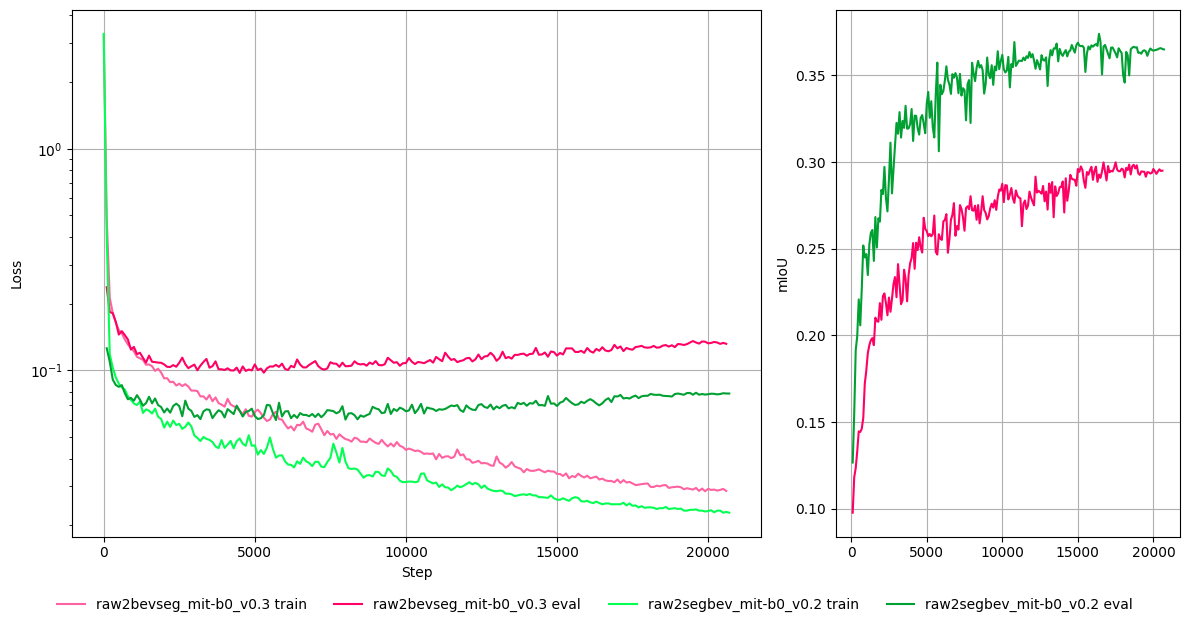

In [15]:
# WITHOUT DATA AUGMENTATION
fig, axes = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(12, 6),gridspec_kw={'width_ratios': [2, 1]} )
plot_train_vs_eval_loss(bev_logs, "raw2bevseg_mit-b0_v0.3", colors = (COLOR_PALETTE[1], COLOR_PALETTE[0]), ax=axes[0])
plot_train_vs_eval_loss(nu_logs, "raw2segbev_mit-b0_v0.2", colors = (COLOR_PALETTE[7], COLOR_PALETTE[6]), ax=axes[0])
plot_mIoU(bev_logs, "raw2bevseg_mit-b0_v0.3", color = COLOR_PALETTE[0], ax=axes[1])
plot_mIoU(nu_logs, "raw2segbev_mit-b0_v0.2", color = COLOR_PALETTE[6], ax=axes[1])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels,loc='lower center',ncol=4,bbox_to_anchor=(0.5, -0.05),frameon=False)

axes[0].set_xlabel("Step")
axes[0].set_ylabel("Loss")
axes[0].set_yscale('log')
axes[0].grid(True)

axes[1].set_ylabel("mIoU")
axes[1].grid(True)

plt.tight_layout()
plt.show()

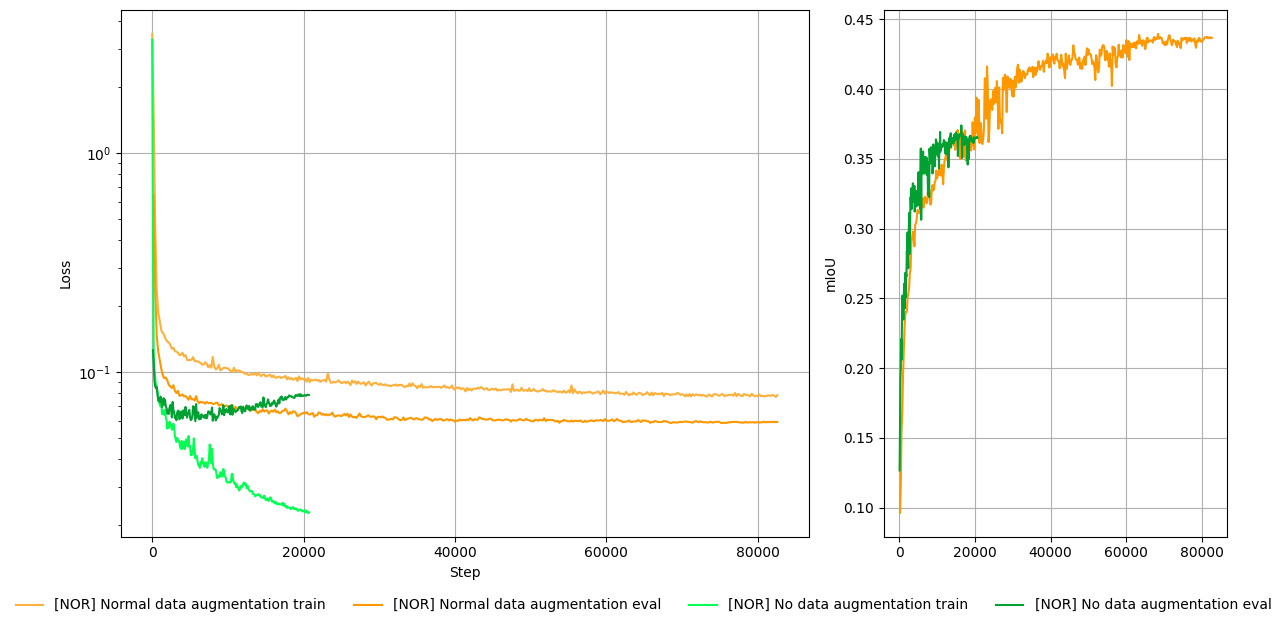

In [8]:
# [NOR] DATA AUG COMP
fig, axes = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(12, 6),gridspec_kw={'width_ratios': [2, 1]} )
plot_train_vs_eval_loss(nu_logs, "raw2segbev_mit-b0_v0.3", label_name="[NOR] Normal data augmentation", colors = (COLOR_PALETTE[9], COLOR_PALETTE[8]), ax=axes[0])
plot_mIoU(nu_logs, "raw2segbev_mit-b0_v0.3", label_name="[NOR] Normal data augmentation", color = COLOR_PALETTE[8], ax=axes[1])
plot_train_vs_eval_loss(nu_logs, "raw2segbev_mit-b0_v0.2", label_name="[NOR] No data augmentation", colors = (COLOR_PALETTE[7], COLOR_PALETTE[6]), ax=axes[0])
plot_mIoU(nu_logs, "raw2segbev_mit-b0_v0.2", label_name="[NOR] No data augmentation", color = COLOR_PALETTE[6], ax=axes[1])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels,loc='lower center',ncol=4,bbox_to_anchor=(0.5, -0.05),frameon=False)

axes[0].set_xlabel("Step")
axes[0].set_ylabel("Loss")
axes[0].set_yscale('log')
axes[0].grid(True)

axes[1].set_ylabel("mIoU")
axes[1].grid(True)

plt.tight_layout()
plt.show()

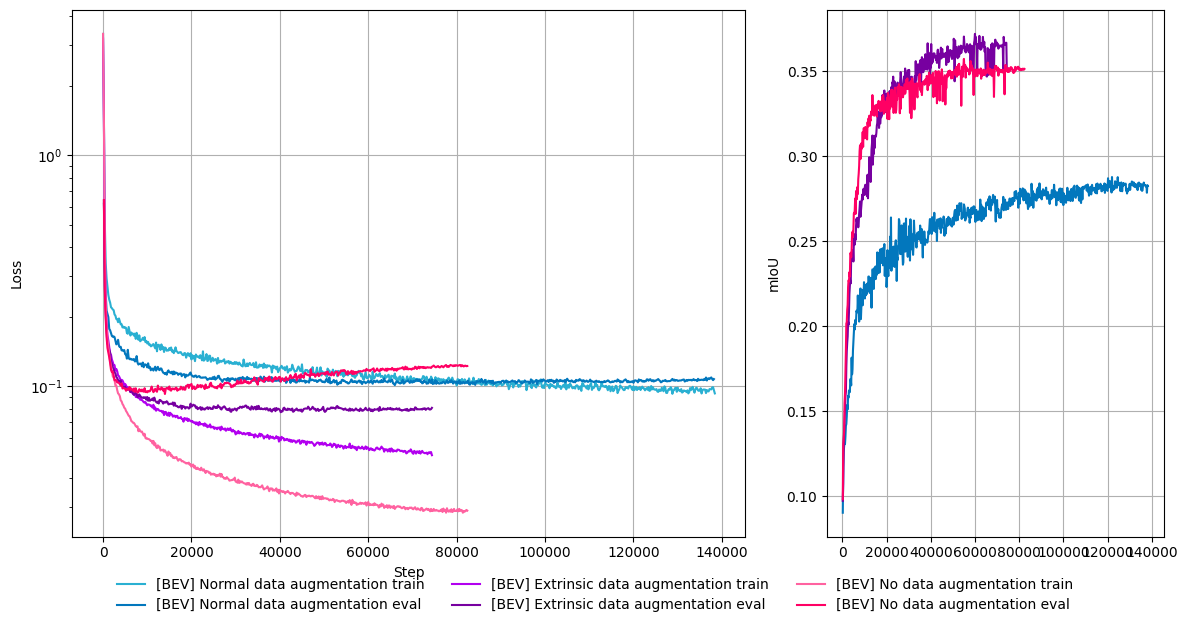

In [18]:
# [BEV] DATA AUG COMP
fig, axes = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(12, 6),gridspec_kw={'width_ratios': [2, 1]} )

plot_train_vs_eval_loss(bev_logs, "raw2bevseg_mit-b0_v0.6", label_name="[BEV] Normal data augmentation", colors = [COLOR_PALETTE[3], COLOR_PALETTE[2]], ax=axes[0])
plot_mIoU(bev_logs, "raw2bevseg_mit-b0_v0.6", label_name="[BEV] Normal data augmentation", color = COLOR_PALETTE[2], ax=axes[1])
plot_train_vs_eval_loss(bev_logs, "raw2bevseg_mit-b0_v0.5_new", label_name="[BEV] Extrinsic data augmentation", colors = [COLOR_PALETTE[5], COLOR_PALETTE[4]], ax=axes[0])
plot_mIoU(bev_logs, "raw2bevseg_mit-b0_v0.5_new", label_name="[BEV] Extrinsic data augmentation", color = COLOR_PALETTE[4], ax=axes[1])
plot_train_vs_eval_loss(bev_logs, "raw2bevseg_mit-b0_v0.4_new", label_name="[BEV] No data augmentation", colors = [COLOR_PALETTE[1], COLOR_PALETTE[0]], ax=axes[0])
plot_mIoU(bev_logs, "raw2bevseg_mit-b0_v0.4_new", label_name="[BEV] No data augmentation", color = COLOR_PALETTE[0], ax=axes[1])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels,loc='lower center',ncol=3,bbox_to_anchor=(0.5, -0.05),frameon=False)

axes[0].set_xlabel("Step")
axes[0].set_ylabel("Loss")
axes[0].set_yscale('log')
axes[0].grid(True)

axes[1].set_ylabel("mIoU")
axes[1].grid(True)

plt.tight_layout()
plt.show()

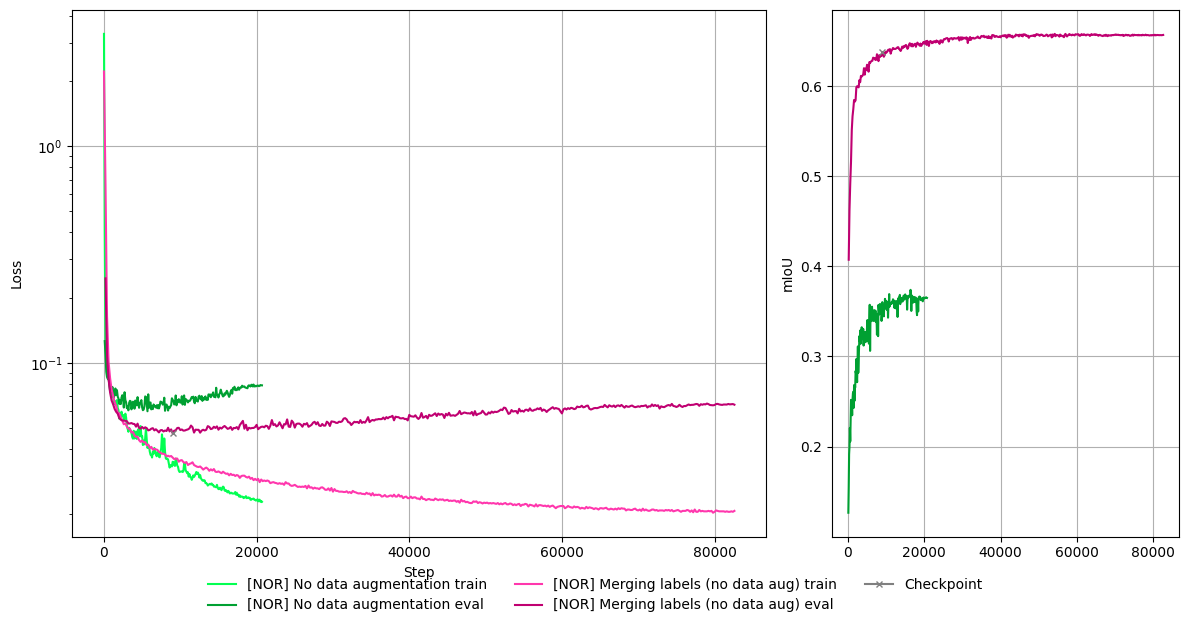

In [17]:
# WITH MERGING LABELS
fig, axes = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(12, 6),gridspec_kw={'width_ratios': [2, 1]} )
plot_train_vs_eval_loss(nu_logs, "raw2segbev_mit-b0_v0.2", label_name="[NOR] No data augmentation", colors = (COLOR_PALETTE[7], COLOR_PALETTE[6]), ax=axes[0])
plot_mIoU(nu_logs, "raw2segbev_mit-b0_v0.2", label_name="[NOR] No data augmentation", color = COLOR_PALETTE[6], ax=axes[1])

plot_train_vs_eval_loss(nu_logs, "raw2segbev_mit-b0_v0.4", label_name="[NOR] Merging labels (no data aug)", checkpoint=9000, colors = (COLOR_PALETTE[11], COLOR_PALETTE[10]), ax=axes[0])
plot_mIoU(nu_logs, "raw2segbev_mit-b0_v0.4", label_name="[NOR] Merging labels (no data aug)", checkpoint=9000, color = COLOR_PALETTE[10], ax=axes[1])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels,loc='lower center',ncol=3,bbox_to_anchor=(0.5, -0.05),frameon=False)

axes[0].set_xlabel("Step")
axes[0].set_ylabel("Loss")
axes[0].set_yscale('log')
axes[0].grid(True)

axes[1].set_ylabel("mIoU")
axes[1].grid(True)

plt.tight_layout()
plt.show()

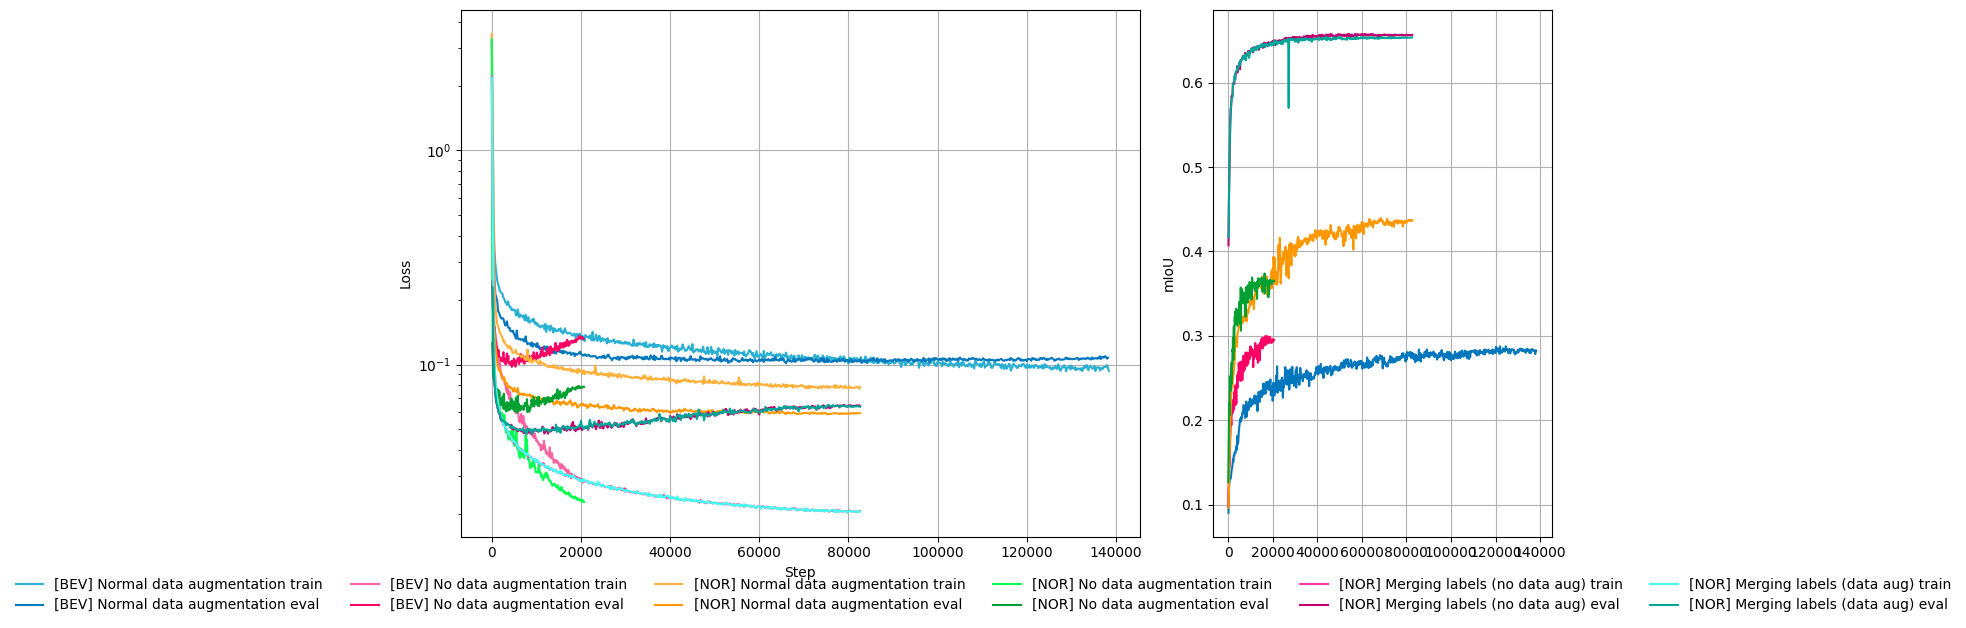

In [9]:
# DATA AUGMENTATION COMP
fig, axes = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(12, 6),gridspec_kw={'width_ratios': [2, 1]} )

# RAW -> BEV -> SEG
plot_train_vs_eval_loss(bev_logs, "raw2bevseg_mit-b0_v0.6", label_name="[BEV] Normal data augmentation", colors = [COLOR_PALETTE[3], COLOR_PALETTE[2]], ax=axes[0])
plot_mIoU(bev_logs, "raw2bevseg_mit-b0_v0.6", label_name="[BEV] Normal data augmentation", color = COLOR_PALETTE[2], ax=axes[1])
# plot_train_vs_eval_loss(bev_logs, "raw2bevseg_mit-b0_v0.5", label_name="[BEV] Extrinsic data augmentation", colors = [COLOR_PALETTE[5], COLOR_PALETTE[4]], ax=axes[0])
# plot_mIoU(bev_logs, "raw2bevseg_mit-b0_v0.5", label_name="[BEV] Extrinsic data augmentation", color = COLOR_PALETTE[4], ax=axes[1])
plot_train_vs_eval_loss(bev_logs, "raw2bevseg_mit-b0_v0.3", label_name="[BEV] No data augmentation", colors = [COLOR_PALETTE[1], COLOR_PALETTE[0]], ax=axes[0])
plot_mIoU(bev_logs, "raw2bevseg_mit-b0_v0.3", label_name="[BEV] No data augmentation", color = COLOR_PALETTE[0], ax=axes[1])

# RAW -> SEG -> BEV
plot_train_vs_eval_loss(nu_logs, "raw2segbev_mit-b0_v0.3", label_name="[NOR] Normal data augmentation", colors = (COLOR_PALETTE[9], COLOR_PALETTE[8]), ax=axes[0])
plot_mIoU(nu_logs, "raw2segbev_mit-b0_v0.3", label_name="[NOR] Normal data augmentation", color = COLOR_PALETTE[8], ax=axes[1])
plot_train_vs_eval_loss(nu_logs, "raw2segbev_mit-b0_v0.2", label_name="[NOR] No data augmentation", colors = (COLOR_PALETTE[7], COLOR_PALETTE[6]), ax=axes[0])
plot_mIoU(nu_logs, "raw2segbev_mit-b0_v0.2", label_name="[NOR] No data augmentation", color = COLOR_PALETTE[6], ax=axes[1])
plot_train_vs_eval_loss(nu_logs, "raw2segbev_mit-b0_v0.4", label_name="[NOR] Merging labels (no data aug)", colors = (COLOR_PALETTE[11], COLOR_PALETTE[10]), ax=axes[0])
plot_mIoU(nu_logs, "raw2segbev_mit-b0_v0.4", label_name="[NOR] Merging labels (no data aug)", color = COLOR_PALETTE[10], ax=axes[1])
plot_train_vs_eval_loss(nu_logs, "raw2segbev_mit-b0_v0.5", label_name="[NOR] Merging labels (data aug)", colors = (COLOR_PALETTE[13], COLOR_PALETTE[12]), ax=axes[0])
plot_mIoU(nu_logs, "raw2segbev_mit-b0_v0.5", label_name="[NOR] Merging labels (data aug)", color = COLOR_PALETTE[12], ax=axes[1])


handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels,loc='lower center',ncol=6,bbox_to_anchor=(0.5, -0.05),frameon=False)

axes[0].set_xlabel("Step")
axes[0].set_ylabel("Loss")
axes[0].set_yscale('log')
axes[0].grid(True)

axes[1].set_ylabel("mIoU")
axes[1].grid(True)

plt.tight_layout()
plt.show()